# Simple Demo: Step Function
This example is taken (with a bit of adaption) from [here](https://github.com/ICL-SML/Doubly-Stochastic-DGP/blob/master/demos/demo_1D_regression.ipynb). The example illustrate a deepGP fit for a step function. Normal GPs with stationary kernels usually fail at this task. We start with some imports.

In [1]:
# useful imports
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# dgplib imports
from dgplib.layers import Layer
from dgplib.cascade import Sequential

from dgplib import DSDGP

In [3]:
# gpflow imports
import gpflow

from gpflow.kernels import RBF, White, Matern52
from gpflow.likelihoods import Gaussian
from gpflow.mean_functions import Linear
from gpflow.utilities import set_trainable, print_summary

gpflow.config.set_summary_fmt("notebook")

## Data
We start of by generating the training and test data:

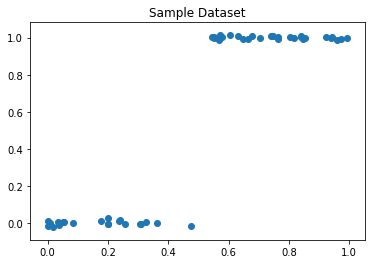

In [4]:
Ns = 300
Xs = np.linspace(-0.5, 1.5, Ns)[:, None]

N, M = 50, 25
X = np.random.uniform(0, 1, N)[:, None]
Z = np.random.uniform(0, 1, M)[:, None]
f_step = lambda x: 0. if x<0.5 else 1.
Y = np.reshape([f_step(x) for x in X], X.shape) + np.random.randn(*X.shape)*1e-2

def plot_data(X, Y):
    plt.title('Sample Dataset')
    plt.scatter(X, Y)
    plt.show()
    
plot_data(X, Y)

## Model Construction
We move on to constructing the model. First we initialize the layers. In this example we are using a 2-layer DGP, an input layer and an output layer.

In [5]:
# Layers
input_layer = Layer(
    input_dim=1,
    output_dim=1, 
    kernel=RBF(lengthscale=0.2, variance=1.) + White(variance=1e-5), 
    num_inducing=M,
    mean_function=Linear()
)

input_layer.q_sqrt.assign(input_layer.q_sqrt * 1e-5)

output_layer = Layer(
    input_dim=1, 
    output_dim=1,
    kernel=RBF(lengthscale=0.2, variance=1.) + White(variance=1e-5),
    num_inducing=M
)

W0723 13:57:01.752855 139838450616128 deprecation.py:323] From /home/ayman/anaconda3/envs/multitask-gpflow-2.0/lib/python3.7/site-packages/tensorflow_probability/python/internal/distribution_util.py:1846: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Next, we wrap the layers around a `Sequential` object. This takes care of initializing the inducing inputs when fed into the model.

In [6]:
seq = Sequential([input_layer, output_layer])

Finally, we create and compile a model object.

In [7]:
model = DSDGP(Z=Z, layers=seq, likelihood=Gaussian())

In [8]:
print_summary(model)

name,class,transform,trainable,shape,dtype,value
DSDGP.likelihood.variance,Parameter,Softplus,True,(),float32,1


## Training
We train the model by maximising the variational lower bound on the log marginal likelihood. We use the Adam optimiser packaged with `GPflow` for this task.

In [9]:
model.compute_log_likelihood()

AttributeError: 'DSDGP' object has no attribute 'compute_log_likelihood'

In [ ]:
opt = gpflow.train.AdamOptimizer(0.01)
opt.minimize(model, maxiter=1000)

In [ ]:
model.compute_log_likelihood()

We can see that the bound on log marginal likelihood has increased.

## Testing
We now test our model.

In [ ]:
samples, mu, sigma = model.predict_all_layers_full_cov(Xs, 10)
plt.plot(Xs, mu[-1][:, :, 0].T, color='r', alpha=0.3)

plt.title('2 layer DGP')
plt.scatter(X, Y)
plt.show()

In [ ]:
for _ in range(10):
    mu, sigma = model.predict_f_full_cov(Xs, 1)
    plt.plot(Xs, mu.reshape(Xs.shape), color='r', alpha=0.2)
    
plt.title('DeepGP Fit')
plt.scatter(X, Y);